In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(16, 2, stride=2)
        
        self.linear = nn.Linear(16, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        return self.linear(out)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = ResNet9(num_classes=100)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    acc = 100. * correct / total
    return train_loss / len(train_loader), acc

In [7]:
def validate():
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    acc = 100. * correct / total
    return val_loss / len(val_loader), acc

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            correct_top1 += predicted.eq(targets).sum().item()

            _, top5_pred = outputs.topk(5, 1, True, True)
            correct_top5 += top5_pred.eq(targets.view(-1, 1)).sum().item()

            total += targets.size(0)

    acc_top1 = 100. * correct_top1 / total
    acc_top5 = 100. * correct_top5 / total

    print("\nTest Results:")
    print(f"Top-1 Accuracy: {acc_top1:.2f}%")
    print(f"Top-5 Accuracy: {acc_top5:.2f}%")
    return acc_top1

Training: 100%|█| 20/20 [05:57<00:00, 17.86s/it, Train Loss=1.673, Val Acc=43.54


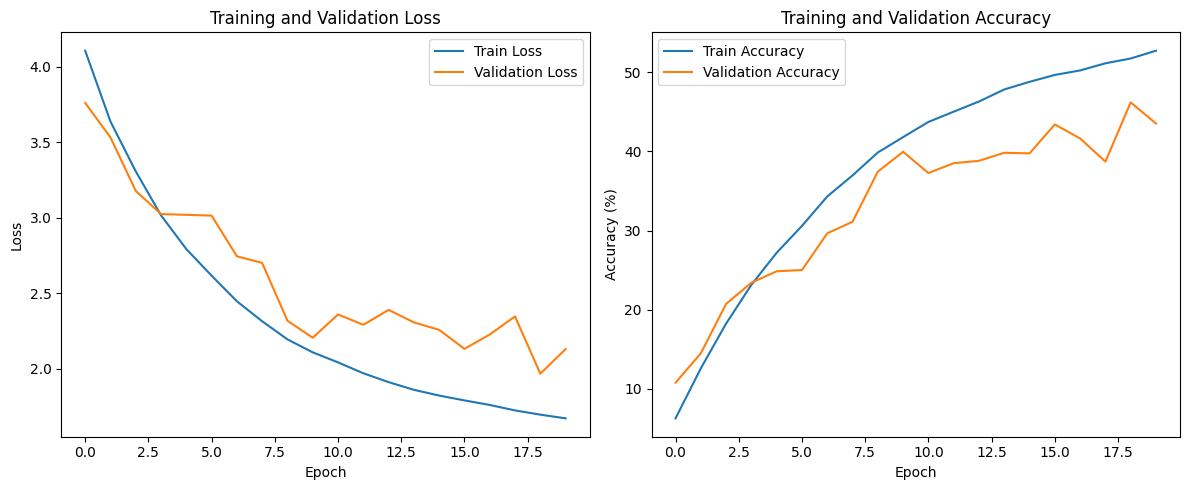


Final Test Results:

Test Results:
Top-1 Accuracy: 43.45%
Top-5 Accuracy: 75.71%


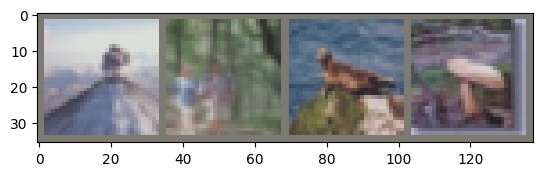

GroundTruth: 49 33 72 51

Predictions:
Predicted: 76 33 55 51


In [9]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_acc = 0

with tqdm(range(20), desc='Training', file=sys.stdout, colour='green') as pbar:
    for epoch in pbar:
        train_loss, train_acc = train(epoch)
        val_loss, val_acc = validate()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
            
        pbar.set_postfix({
            'Train Loss': f'{train_loss:.3f}',
            'Val Acc': f'{val_acc:.2f}%',
            'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
        })

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Test Results:")
test()

def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(f'{labels[j]}' for j in range(4)))

print("\nPredictions:")
outputs = model(images[:4].to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{predicted[j].item()}' for j in range(4)))